# DS 7331 Data Mining
### Logistic Regression and SVM
### Mini Lab
* Allen Ansari<br>
* Chad Madding<br>
* Yongjun (Ian) Chu<br>

## Introduction
Cardiovascular diseases (CVD) are the no. 1 cause of death in US each year. To reduce the death rate, the best approach is by early detection and screening. In this Mini Lab we will implemented Logistic Regression (Logit) and Support Vector Machine (SVM) to look at predicting the probability of a patient having CVD based on results from medical examinations, such as blood pressure values and glucose content. The following categories are used for the analysis:

**1) Model Creation**
- Create a logistic regression model and a support vector machine model for the classification task involved with our dataset. 
- Assess how well each model performs (use 80/20 training/testing split for your data).
- Adjust parameters of the models to make them more accurate. The SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

**2) Model Advantages**
- Discuss the advantages of each model for each classification task. 
- Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

**3) Interpret Feature Importance**
- Use the weights from logistic regression to interpret the importance of different features for the classification task.
- Explain your interpretation in detail. Why do you think some variables are more important?

**4) Interpret Support Vectors**
- Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

### Choosing the cadiovascular diseases dataset
Cardiovascular diseases (CVD) are the no. 1 cause of death in US each year. To reduce the death rate, the best approach is by early detection and screening. An efficient way would be to predict the probability of a patient having CVD based on results from medical examinations, such as blood pressure values and glucose content. 

Here, we obtained a CVD dataset from Kaggle. It consists of 70,000 records of patients data in 12 features, such as age, gender, systolic blood pressure, diastolic blood pressure and CVD status(binary, 1 or 0). The purpose of this dataset was to determine which medical aspects had the most bearing on whether a patient would had CVD or not. 

To mine useful knowledge from the dataset, we will establish a prediction algorithm chosen from some commonly used classification models, including logistic regression, to find a relationship between a specific attribute or group of attributes and the probability of having CVD for a patient. To measure the effectiveness of our prediction algorithm, we will use the cross-validation. For each evaluation, accuracy metric for binary classification models called Area Under the (Receiver Operating Characteristic) Curve (AUC) will be generated. AUC measures the ability of the model to predict a higher score for positive examples as compared to negative examples. We can get the overall performance measure by computing the average of the AUC metrics from cross-validations for any particular model. Results from different models will be compared and the best one(s) will be chosen.

### Data description

We will be performing an analysis of a cleaned up cardiovascular diseases dataset we used from the Lab 1 assignment.

Our task is to predict the presence or absence of cardiovascular disease (CVD) using the patient examination results. 

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

|Feature   |Variable Type   |Variable   |Value Type   |
|:---------|:--------------|:---------------|:------------|
| Gender | Objective Feature | gender | categorical code |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
| Years | Objective Feature | years | age in years |
| BMI | Objective Feature | bmi | bmi |

For any binary data type, "0" means "No" and "1" means "Yes". All of the dataset values were collected at the moment of medical examination.

In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

#import warnings
#warnings.simplefilter('ignore', DeprecationWarning)
#warnings.simplefilter('ignore', FutureWarning)

from pandas.plotting import scatter_matrix

#Bring in data set
df = pd.read_csv('data/cardio_clean.csv') #read in the csv file

# Show the dimention and the first 5 rows of the dataset
print(df.shape)
df.head()

(63055, 13)


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years,BMI
0,2,168,62.0,110,80,1,1,0,0,1,0,50,2
1,1,156,85.0,140,90,3,1,0,0,1,1,55,4
2,1,165,64.0,130,70,3,1,0,0,0,1,52,2
3,2,169,82.0,150,100,1,1,0,0,1,1,48,3
4,1,156,56.0,100,60,1,1,0,0,0,0,48,2


## 1. Model Creation

### A. Logistic Regression

#### A1. Initial model build

#### SGDClassifier Over the Other Sklearn Functions

First, we used SVC setting kernel = 'linear' but waited a long time for it to finish. Then we used LogisticRegression and checked accuracy and precision.

At the end we tried SGDClassifier with loss = 'log' which was exponentially faster than the others so this is what we use for logistic regression.

In [2]:
#separating data into two parts X (features) and Y (target)
features = ["gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "years", "BMI"]
# Separating out the features
X = df.loc[:, features].values

#Separating out the target
Y = df.loc[:, ['cardio']].values.ravel()
Y.shape


(63055,)

### Logistic Regression
For the logistic regression model, we created a function that took in X_train and Y_train from the original data set to test for X_test from the modified dataset. The accuracy of the logistic regression prediction for positive or negative cardio was compared with that of the original, where a confusion matrix was made to show percentage accuracy. Along with accuracy precision,MAE,RSME and MAPE for each split will be shown. Average Accuracy, Precision, MAE, RSME and MAPE for 10 folds cross validation is more than 0.72, 0.724, 0.279, 0.528 and 34.741 respectively.

In [3]:
#Building a logistic regression model with default values for parameters

#apply cross validation, using 80/20 train/test splitting
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)

#apply standard scaling: to standard normally distributed data
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

from sklearn import metrics as mt
#apply logistic regression
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression(solver='lbfgs', multi_class='auto')


for train_indices, test_indices in cv.split(X,Y): 
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    regEstimator.fit(X_train_scaled, Y_train)  # train object
    y_hat = regEstimator.predict(X_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print('accuracy:', acc )
    print(conf)

accuracy: 0.7222266275473793
[[5060 1384]
 [2119 4048]]
accuracy: 0.7199270478153993
[[4966 1332]
 [2200 4113]]


Using default values for logistic regression model, we obtained an accuracy value around 72%. Can we increase the accuracy by optimizing the parameter value settings?

#### A2. Find the best logistic regression parameter settings
By running logistic regression  one time with the built in parameters for both LogisticRegression and SGDClassifier, we got an average accuracy of 0.71 from 10 splits. To try to improve this, we are doing following steps.

first, for LogisticRegression function we want to see how changing the value of C, class_weight, random_state, max_iter and penalty will affect the accuracy. To do this we are using GridSearchCV function to check 'C' value between 0.001, 0.01, 0.1, 1, 10, 100 and 1000. Also sets penalty as L2 and 'class_weight'to 'balanced' and 'none'. we also assign 0 and 'lbfgs' for random_state and solver respectively. max_iter will be defined between 1500 and 2000.

In [4]:
#divide data into two parts X(features) and Y(target)
df_1 = df.copy()
X1 = df_1[features].copy()

Y1= df_1[['cardio']].copy()
Y1.shape

(63055, 1)

In [5]:
#Divide data into test and training splits and having 10-fold CV
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [6]:
#Classifier Evaluation

from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, Y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, Y, scoring=['accuracy','precision']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"


    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, Y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

In [7]:
#data scaling
scaler = StandardScaler()
scaler.fit(X)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analysis 
X_Scl = scaler.transform(X)

In [8]:
#Logisitic regression 10-fold cross-validation 

regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[1500,2000]
             }

#Create a grid search object using the above parameters 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_Scl, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   10.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [1500, 2000], 'penalty': ['l2'],
                         'random_state': [0], 'solver': ['lb

In [9]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1500, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
#Use the best parameters for our Logistic Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.7209
The average precision for all cv folds is: 			 0.74509
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision
0,0.721989,0.742041
1,0.721672,0.751932
2,0.724526,0.738231
3,0.722227,0.753943
4,0.720324,0.747732
5,0.715407,0.740883
6,0.719689,0.740822
7,0.723892,0.747845
8,0.714614,0.743851
9,0.724685,0.743580


Second, we want to see how changing the value of alpha, epsilon, number of iterations, and penalty will affect the accuracy for SGDClassifier model. To do this we have another 'For' loop which sets alpha and epsilon at ten and twenty linear increments from 0.00001 to 0.001 and 0.01 to .5, respectively. The number of iterations could be 1, 3, 6, 10, or 15 and penalty could be L1 or L2.

The optimal values will be stored at best_params_logistic variable and will used to fit for final model.

The optimal value for alpha we found is 0.00034 and that for epsilon is 0.371. The optimal penalty is L2 at 15 iterations.Alpha is just a constant multiplied to the regularization term so our value of 0.00034 is expected.

We found L2, the squared error, is slightly more accurate than L1, the error. This was expected because L2 is typically better for minimizing error than L1 and L2 is standard for linear SVM models, where it performed the best for our model.

The iteration number vs accuracy should be a fairly random distribution. We expected to get different results each time and expected that they would be about our initial accuracy, 71%.

In [11]:
EvaluateClassifierEstimator2(classifierEst, X_Scl, Y, 10)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     31969
           1       0.75      0.66      0.70     31086

    accuracy                           0.72     63055
   macro avg       0.72      0.72      0.72     63055
weighted avg       0.72      0.72      0.72     63055

[[24929  7040]
 [10471 20615]]
0.7222900642296408


It appears that even using the optimized logistic regression parameter settings, the accuracy remains essentially the same, that is, around 0.72.

#### A3. Feature Importance for the Top Performing Model obtained from A2

In [12]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_Scl, Y)

from sklearn.metrics import confusion_matrix

In [13]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
print(weights)
feature_names = X1.columns.values
print(feature_names)
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

[-0.01232388 -0.03460588  0.13093432  0.87404364  0.10307929  0.33206127
 -0.06173768 -0.04372104 -0.05084699 -0.09244061  0.34658759  0.0041909 ]
['gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol' 'gluc' 'smoke'
 'alco' 'active' 'years' 'BMI']


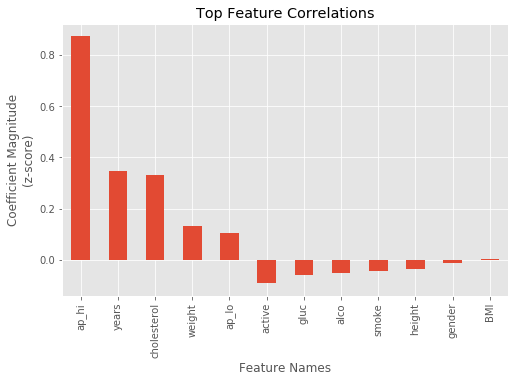

In [14]:
# Examine variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(8,5))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

Text(0.5,0,'Coefficient Magnitude\n(z-score)')

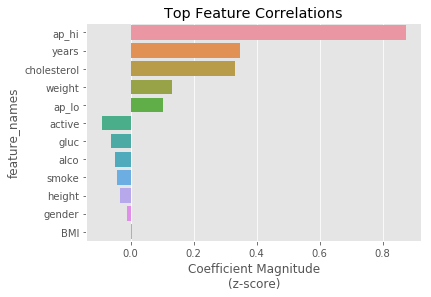

In [15]:
#drawing the coefficients with SNS
import seaborn as sns
ax = sns.barplot(x =linreg_ft_imp_df['weights'], y = linreg_ft_imp_df['feature_names'], orient= 'h')
ax.set_title("Top Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")

#### A4. Finding the most influential features by Recursive Feature Elimination method

In [16]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
      estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=1500,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=0, solver='lbfgs',
                                   tol=0.0001, verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Optimal number of features : 10


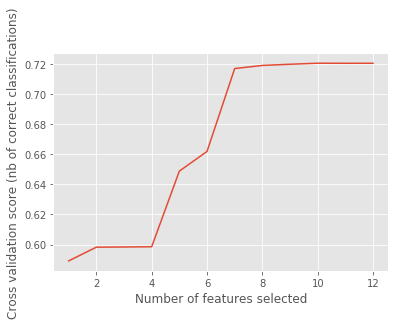

In [17]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [18]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X1.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

features = rfe_ft_imp_df

features

,feature_names,weights
9,active,0.720490
11,BMI,0.720450
10,years,0.720442
8,alco,0.719808
7,smoke,0.719007
6,gluc,0.716946
5,cholesterol,0.661851
4,ap_lo,0.648783
3,ap_hi,0.598517
2,weight,0.598359


#### A5. Combining everything together

In [19]:
#best-feature, scaling, cross-validation, GRID search
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[1500,2000]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1500,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [20]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, Y, cv)

The average accuracy for all cv folds is: 			 0.72073
The average precision for all cv folds is: 			 0.74491
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision
0,0.722544,0.742899
1,0.721672,0.752023
2,0.725874,0.738768
3,0.721434,0.753592
4,0.721196,0.749643
5,0.714297,0.739864
6,0.718420,0.739803
7,0.722940,0.746148
8,0.713742,0.742609
9,0.725161,0.743772


In [21]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, Y, 10)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     31969
           1       0.75      0.66      0.70     31086

    accuracy                           0.72     63055
   macro avg       0.72      0.72      0.72     63055
weighted avg       0.72      0.72      0.72     63055

[[24913  7056]
 [10471 20615]]
0.7220363175005947


In [22]:
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
print(weights)

[ 0.00223196  0.87733104  0.10624832  0.33287877 -0.06061475 -0.0440466
 -0.05033992 -0.09325165  0.34468309  0.11134968]


In [23]:
#Looking at RFECV Feature Importance after using a Pipeline

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()

feature_names = X1.columns.values[rfecv.get_support(indices=True)]
print(feature_names)
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

['gender' 'ap_hi' 'ap_lo' 'cholesterol' 'gluc' 'smoke' 'alco' 'active'
 'years' 'BMI']


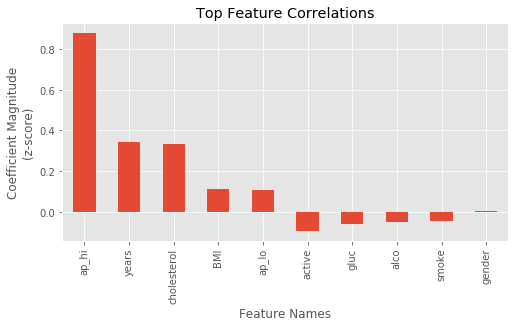

In [55]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(8,4))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

Text(0.5,0,'Coefficient Magnitude\n(z-score)')

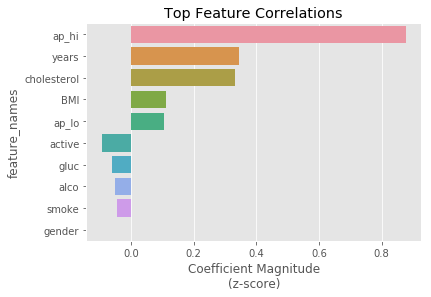

In [25]:
import seaborn as sns

ax=sns.barplot(x =linreg_ft_imp_df['weights'], y = linreg_ft_imp_df['feature_names'], orient= 'h')
ax.set_title("Top Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")


### B. SVM

#### B1.  Initial SVM model build

In [26]:
#the following will generate matrix for X and Y
features = ["gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "years", "BMI"]
# Separating out the features
X = df.loc[:, features].values

#Separating out the target
Y = df.loc[:, ['cardio']].values.ravel()


In [27]:
%%time
# Using default setting of SVM, we ran through the cross validation loop and set the training and testing variable for one single iteration
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)
scl_obj = StandardScaler()
svm_clf = SVC() # get object (C=0.5, kernel='linear', degree=3, gamma='auto')

for train_indices, test_indices in cv.split(X,Y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    svm_clf.fit(X_train_scaled, Y_train)  # train object
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print('accuracy:', acc )
    print(conf)
    

accuracy: 0.7271429704226469
[[5103 1341]
 [2100 4067]]
accuracy: 0.7289667750376655
[[5039 1259]
 [2159 4154]]
Wall time: 3min 44s


Using default values for support vector machine (SVM) model, we obtained an accuracy value close to 73%. Can we increase the accuracy by optimizing the parameter value settings? However, the run time for SVM model is much longer than the value with Logistic regression. A single run would take more than 2 mins to finish. For a grid search, which would take about 300 runs, it would take 8-10 hours to finish for SVM model. As a comparison, for logistic regression, a single run takes less than 1 second. Therefore, we decided to use the stochastic gradient descent (SGD) Classifier on SVM to reduce the computing time.  

#### B2. An initial run of SVM_SGD classifier 

In [28]:
%%time
# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt

cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_jobs=-1, penalty='l2', random_state = 0)

#n_iter=iterations

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,Y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),Y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('SVM: ', acc)
print('Confusion marix: ', conf)

SVM:  0.713107604472286
Confusion marix:  [[5148 1151]
 [2467 3845]]
Wall time: 445 ms


#### B3. Find the best SVM_SGD classifier parameter settings

In [29]:
#Divide data into test and training splits and having 10-fold CV
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

#data scaling
scaler = StandardScaler()
scaler.fit(X)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analysis 
X_Scl = scaler.transform(X)

In [30]:
#SVM_SGD 10-fold cross-validation 

SGDEstimator = SGDClassifier()

parameters = { 'loss': ['hinge']
              ,'penalty':['l2']
              ,'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
              ,'class_weight': ['balanced', None]
              ,'random_state': [0]
              ,'max_iter':[1000,1500]
             }

#Create a grid search object using the above parameters 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=SGDEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_Scl, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   11.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penal...
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None], 

In [31]:
#Display the best estimator parameters
regGridSearch.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
#Use the best parameters for our Logistic Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.71818
The average precision for all cv folds is: 			 0.76258
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision
0,0.719927,0.762502
1,0.722227,0.769881
2,0.721513,0.755728
3,0.718103,0.771256
4,0.714614,0.759816
5,0.713425,0.759466
6,0.716042,0.756501
7,0.721751,0.766842
8,0.711442,0.758511
9,0.722782,0.765259


In [33]:
EvaluateClassifierEstimator2(classifierEst, X_Scl, Y, 10)

              precision    recall  f1-score   support

           0       0.69      0.81      0.75     31969
           1       0.76      0.63      0.69     31086

    accuracy                           0.72     63055
   macro avg       0.73      0.72      0.72     63055
weighted avg       0.73      0.72      0.72     63055

[[25962  6007]
 [11653 19433]]
0.7199270478153993


It appears that even using the optimized SGD parameter settings, the accuracy remains essentially the same, that is, close to 0.72.

#### B4. Feature Importance for the Top Performing Model obtained from B3

In [34]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_Scl, Y)

from sklearn.metrics import confusion_matrix

In [35]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
print(weights)
feature_names = X1.columns.values
print(feature_names)
linSVMSGD_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linSVMSGD_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

[ 0.00131922 -0.03908046  0.10832087  0.8733281   0.11169506  0.36550997
 -0.02396304 -0.03082893 -0.03910795 -0.06280961  0.24267512  0.02317309]
['gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol' 'gluc' 'smoke'
 'alco' 'active' 'years' 'BMI']


Text(0.5,0,'Coefficient Magnitude\n(z-score)')

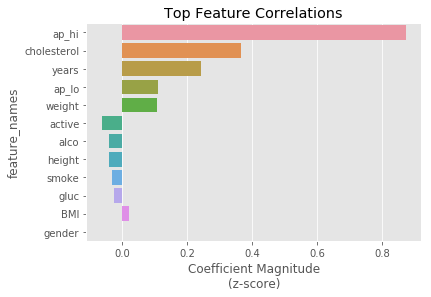

In [36]:
#drawing the coefficients with SNS
import seaborn as sns
ax = sns.barplot(x =linSVMSGD_ft_imp_df['weights'], y = linSVMSGD_ft_imp_df['feature_names'], orient= 'h')
ax.set_title("Top Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")

#### B5. Finding the most influential features by Recursive Feature Elimination method

In [37]:
from sklearn.feature_selection import RFECV

#Create an estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
      estimator=SGDClassifier(alpha=0.01, average=False,
                              class_weight='balanced', early_stopping=False,
                              epsilon=0.1, eta0=0.0, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='optimal',
                              loss='hinge', max_iter=1000, n_iter_no_change=5,
                              n_jobs=None, penalty='l2', power_t=0.5,
                              random_state=0, shuffle=True, tol=0.001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Optimal number of features : 7


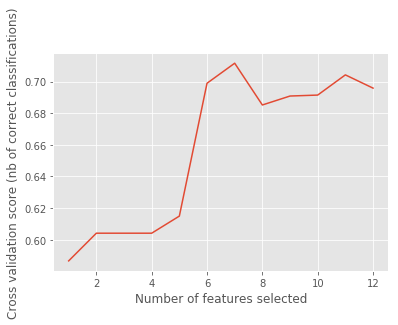

In [38]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [39]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X1.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

features = rfe_ft_imp_df

features

,feature_names,weights
6,gluc,0.711601
10,years,0.704226
5,cholesterol,0.698930
11,BMI,0.695845
9,active,0.691452
8,alco,0.690849
7,smoke,0.685188
4,ap_lo,0.614923
1,height,0.604108
2,weight,0.604108


#### B6. Combining everything together

In [40]:
#best-feature, scaling, cross-validation, GRID search
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), SGDClassifier())

# Define a range of hyper parameters for grid search
parameters = { 'sgdclassifier__loss':['hinge']
              ,'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
              ,'sgdclassifier__class_weight': ['balanced',None]
              ,'sgdclassifier__random_state': [0]
              ,'sgdclassifier__penalty': ['l2']
              ,'sgdclassifier__max_iter':[1000,1500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                               loss='hinge', max_iter=1000, n_iter_no_change=5,
                               n_jobs=None, penalty='l2', power_t=0.5,
                               random_state=0, shuffle=True, tol=0.001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False))],
         verbose=False)

In [41]:
classifierEst.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [42]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, Y, cv)

The average accuracy for all cv folds is: 			 0.71296
The average precision for all cv folds is: 			 0.76668
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision
0,0.716359,0.756030
1,0.715566,0.772600
2,0.717072,0.755046
3,0.713028,0.772782
4,0.711205,0.742199
5,0.709143,0.765514
6,0.709460,0.756773
7,0.714138,0.780592
8,0.710729,0.773920
9,0.712949,0.791330


In [43]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, Y, 10)

              precision    recall  f1-score   support

           0       0.67      0.84      0.75     31969
           1       0.78      0.58      0.67     31086

    accuracy                           0.71     63055
   macro avg       0.73      0.71      0.71     63055
weighted avg       0.72      0.71      0.71     63055

[[26760  5209]
 [12956 18130]]
0.7119181666798826


In [44]:
weights = grid.best_estimator_.named_steps['sgdclassifier'].coef_.ravel()
print(weights)

[-0.00433382  1.16902335  0.48358736  0.0177862   0.08723532  0.03772865
  0.12720753]


In [45]:
#Looking at RFECV Feature Importance after using a Pipeline

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['sgdclassifier'].coef_.ravel()

feature_names = X1.columns.values[rfecv.get_support(indices=True)]
print(feature_names)
linSVMSGD_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linSVMSGD_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

['gender' 'ap_hi' 'cholesterol' 'gluc' 'smoke' 'alco' 'BMI']


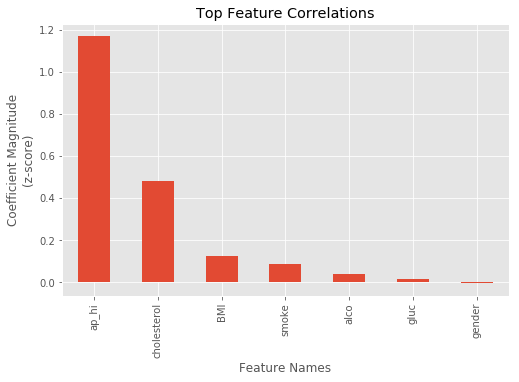

In [46]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linSVMSGD_ft_imp_df

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(8,5))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

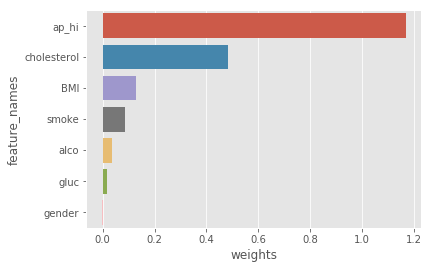

In [47]:
import seaborn as sns

sns.barplot(x =linSVMSGD_ft_imp_df['weights'], y = linSVMSGD_ft_imp_df['feature_names'], orient= 'h')

### 2. Model Advantages

### 3. Interpret the importance of different features for a classification task by using weights from logistic regression

Text(0.5,0,'Coefficient Magnitude\n(z-score)')

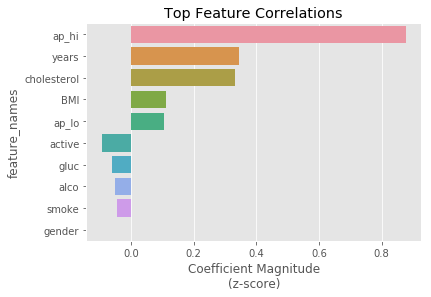

In [48]:
import seaborn as sns

ax=sns.barplot(x =linreg_ft_imp_df['weights'], y = linreg_ft_imp_df['feature_names'], orient= 'h')
ax.set_title("Top Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")


The bar plots above will help interpret the importance of different features for the classification task.

General Observation - It is obvious that Systolic blood pressure (ap_hi) holds the most weight in our prediction. There is a sharp drop to the second and third coefficients; their age in years and the patents cholesterol. The last two positive correlated features are weight and Diastolic blood pressure (ap_lo), theses seem to play less of a roll in the prediction of cardiovascular diseases. Looking at the graph these features fill out the positive correlation, meaning the higher the numbers the greater the risk of having some form of Cardiovascular diseases. This makes since looking at the features in this group. The higher someone’s blood pressure, age or cholesterol the greater the risk. We can now look at the most important negative correlated feature, physical activity. The lower a person’s physical activity level (active) is the more of a predictor of Cardiovascular diseases.

ap_hi – This is the highest influential factor in our analysis. We saw a strong linear relationship between this variable and cardiovascular diseases (cardio). The rate of cardiovascular diseases tends to rise Systolic blood pressure increases.

years – The age of a patent was the second in the prediction of cardo. This would also make since as that the older a person is the more risk of developing cardiovascular problems. We found that the data showed a person in their mid-50’s and older was more at risk.

cholesterol – Cholesterol and years were almost equal in weight meaning the higher the cholesterol the more of a person is at risk of cardiovascular diseases.

weight – Weight was one of the lower predictors but still showed to have slight significances.

ap_lo – One surprising feature to show not much in the predictions was a person’s Diastolic blood pressure (ap_lo). It was the lowest of the positive correlated features.

active - The last feature we would like to point out is the physical activity of the patents. There is significant negative correlation in the prediction. This also was not any new revelation, it basically points out that the less active a person is the more of a predictor of cardiovascular diseases.

### 4. Interpret Support Vectors
For the support vector machine model, we created a function that took in X_train and Y_train from the original data set to test for X_test from the modified dataset. The accuracy of the SVM prediction for positive or negative cardio was compared with that of the original, where a confusion matrix was made to show percentage accuracy. Due to the complexity of the dataset, we are again slightly better than 71% accuracy.

In [49]:
%%time
# Using default setting of SVM, we ran through the cross validation loop and set the training and testing variable for one single iteration
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
scl_obj = StandardScaler()
svm_clf = SVC(kernel='linear', random_state = 0) # get object (C=0.5, kernel='linear', degree=3, gamma='auto')

for train_indices, test_indices in cv.split(X,Y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    svm_clf.fit(X_train_scaled, Y_train)  # train object
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print('accuracy:', acc )
    print(conf)
    

accuracy: 0.7191340892871303
[[5271 1173]
 [2369 3798]]
Wall time: 1min 37s


### Optimizing the Support Vector Machine Model
By running SVM model one time with the built in parameters, we got an average accuracy of 0.71 from 10 splits. To try to improve this, we will do a few things listed below:

First, we want to do the 80/20 split 10 times and average those results to get a better accuracy. By splitting the training and test sets up multiple times, we can minimize the effects of outliers.

Second, we want to see how changing the value of alpha,epsilon, number of iterations, and penalty will affect the accuracy. To do this we have another for loop which sets alpha and epsilon at 10 and 20 linear increments from 0.00001 to 0.01 and 0.01 to 0.5 respectively. The number of iterations could be 10, 15, 30, 60, or 100 and penalty could be L1 or L2.

We found that the optimal value for alpha is 0.00421. The optimal penalty is L2 at 100 iterations.

Alpha is just a constant multiplied to the regularization term so our value of 0.00421 is expected. Alpha could be used again if we set the learning rate to optimal but we will not do that for this mini lab.

Epsilon was not changed because the results had noisy accuracy and we decided to remove it.

We found L2, the squared error, is slightly more accurate than L1, the error. This was expected because L2 is typically better for minimizing error than L1 and L2 is standard for linear SVM models, where it performed the best for our model.

The iteration number vs accuracy should be a fairly random distribution. We expected to get different results each time and expected that they would be about our initial accuracy, 0.53 +/- 0.1. This time, 100 iterations is the optimal number. Although the accuracy per iteration was still going up, we had to stop at 100 iterations due to running time restraints.

In [50]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )
print(svm_clf.support_)

(32921, 12)
(32921,)
[16462 16459]
[    2     6     8 ... 50434 50436 50438]


[[ 3.87046495e-04 -5.70790199e-02  1.11360626e-01  9.34988622e-01
   6.37134915e-02  3.71616778e-01 -2.21105920e-02 -2.95926137e-02
  -3.51684700e-02 -8.38238084e-02  2.30200007e-01  2.57364660e-02]]


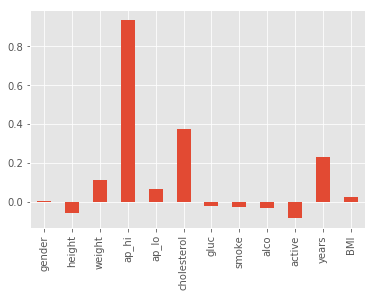

In [51]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X1.columns)
weights.plot(kind='bar')

In [52]:
features = ["gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "years", "BMI"]
# Separating out the features
X = df.loc[:, features].values

#Separating out the target
Y = df.loc[:, ['cardio']].values


In [53]:
# make a dataframe of the training data
df_tested_on = X1.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['cardio'] = Y[svm_clf.support_] # add back in the 'cardio' Column to the pandas dataframe
#df_imputed['cardio'] = Y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32921 entries, 38926 to 21243
Data columns (total 13 columns):
gender         32921 non-null int64
height         32921 non-null int64
weight         32921 non-null float64
ap_hi          32921 non-null int64
ap_lo          32921 non-null int64
cholesterol    32921 non-null int64
gluc           32921 non-null int64
smoke          32921 non-null int64
alco           32921 non-null int64
active         32921 non-null int64
years          32921 non-null int64
BMI            32921 non-null int64
cardio         32921 non-null int64
dtypes: float64(1), int64(12)
memory usage: 3.5 MB


C:\Users\04616598\.conda\envs\ML7331\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


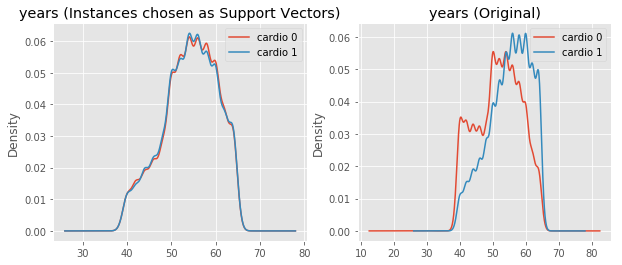

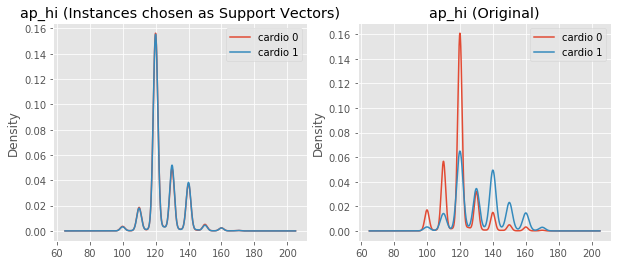

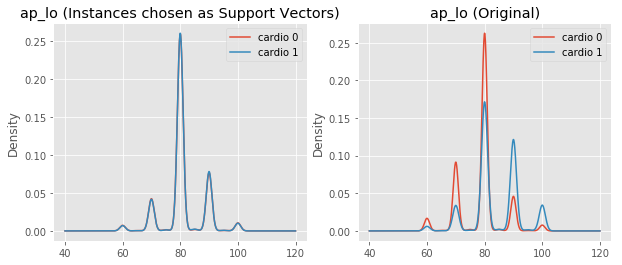

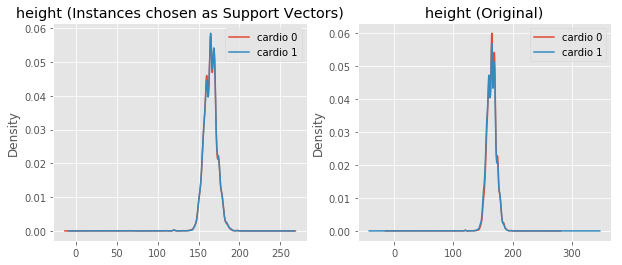

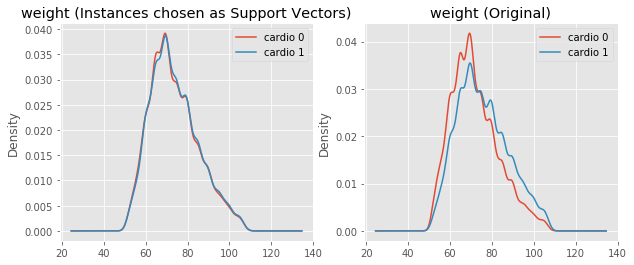

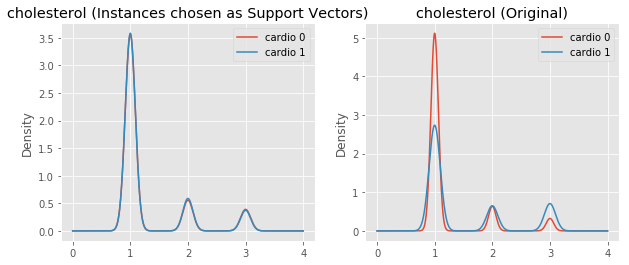

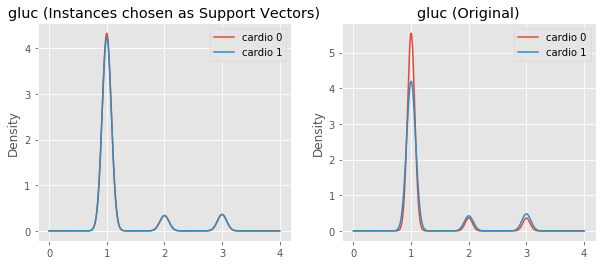

In [54]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['cardio'])
df_grouped = df.groupby(['cardio'])

# plot KDE of Different variables
vars_to_plot =  ['years','ap_hi','ap_lo','height','weight','cholesterol','gluc']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['cardio 0','cardio 1'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['cardio 0','cardio 1'])
    plt.title(v+' (Original)')

